# Comparison between Models
### Imports

In [2]:
import os
import json
import joblib
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score

### Paths

In [3]:
DATA_DIR = "../data/splits"
MODEL_DIR = "../models"
OUTPUT_DIR = "../outputs"

os.makedirs(OUTPUT_DIR, exist_ok=True)

TEST_PATH = f"{DATA_DIR}/test.csv"

DT_MODEL_PATH  = f"{MODEL_DIR}/decision_tree/model.joblib"
XGB_MODEL_PATH = f"{MODEL_DIR}/xgboost/model.joblib"
SVM_MODEL_PATH = f"{MODEL_DIR}/svm/model.joblib"
ENSEMBLE_METRICS_PATH = f"{MODEL_DIR}/ensemble/metrics.json"

TARGET_COL = "target"

### Load Test Dataset

In [ ]:
test_df = pd.read_csv(TEST_PATH)

X_test = test_df.drop(columns=[TARGET_COL])
y_test = test_df[TARGET_COL]

print("Test set size:", X_test.shape)
print("Class distribution:")
print(y_test.value_counts())

Test set size: (664, 36)
Class distribution:
target
Graduate    331
Dropout     214
Enrolled    119
Name: count, dtype: int64


### Load Trained Models

In [ ]:
dt_model  = joblib.load(DT_MODEL_PATH)
xgb_model = joblib.load(XGB_MODEL_PATH)
svm_model = joblib.load(SVM_MODEL_PATH)

print("Models loaded successfully")

Models loaded successfully


### Predictions

In [6]:
dt_preds  = dt_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)
svm_preds = svm_model.predict(X_test)

### Ensemble Results

In [18]:
with open(ENSEMBLE_METRICS_PATH, "r") as f:
    ensemble_metrics = json.load(f)

ensemble_acc = round(ensemble_metrics["accuracy"], 4)
ensemble_f1_weighted = round(
    ensemble_metrics["classification_report"]["weighted avg"]["f1-score"], 4
)
ensemble_f1_macro = round(
    ensemble_metrics["classification_report"]["macro avg"]["f1-score"], 4
)

### Comparison Table

In [19]:
# Define canonical class order
CLASS_ORDER = sorted(y_test.unique().tolist())

# Create id <-> label mapping
id_to_label = {i: label for i, label in enumerate(CLASS_ORDER)}

# Convert numeric XGBoost predictions to string labels
xgb_preds_str = [id_to_label[p] for p in xgb_preds]

results = [
    {
        "Model": "Decision Tree",
        "Accuracy": round(accuracy_score(y_test, dt_preds), 4),
        "F1-score (weighted)": round(f1_score(y_test, dt_preds, average="weighted"), 4),
        "F1-score (macro)": round(f1_score(y_test, dt_preds, average="macro"), 4)
    },
    {
        "Model": "XGBoost",
        "Accuracy": round(accuracy_score(y_test, xgb_preds_str), 4),
        "F1-score (weighted)": round(f1_score(y_test, xgb_preds_str, average="weighted"), 4),
        "F1-score (macro)": round(f1_score(y_test, xgb_preds_str, average="macro"), 4)
    },
    {
        "Model": "SVM",
        "Accuracy": round(accuracy_score(y_test, svm_preds), 4),
        "F1-score (weighted)": round(f1_score(y_test, svm_preds, average="weighted"), 4),
        "F1-score (macro)": round(f1_score(y_test, svm_preds, average="macro"), 4)
    },
    {
        "Model": "Ensemble Voting",
        "Accuracy": ensemble_acc,
        "F1-score (weighted)": ensemble_f1_weighted,
        "F1-score (macro)": ensemble_f1_macro
    }
]

results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,F1-score (weighted),F1-score (macro)
0,Decision Tree,0.7319,0.7321,0.6750
1,XGBoost,0.8042,0.7989,0.7484
2,SVM,0.7018,0.7172,0.6678
3,Ensemble Voting,0.7846,0.7811,0.7293


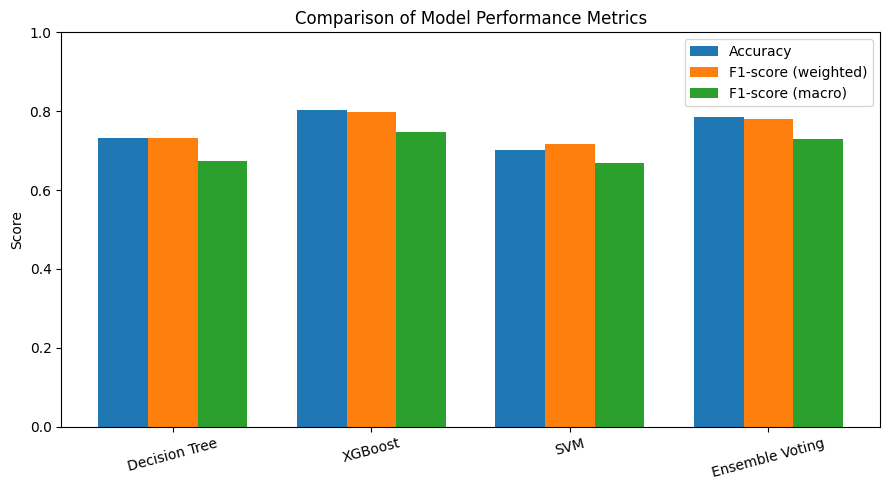

In [20]:
plt.figure(figsize=(9,5))

x = range(len(results_df))

plt.bar(x, results_df["Accuracy"], width=0.25, label="Accuracy")
plt.bar([i + 0.25 for i in x], results_df["F1-score (weighted)"],
        width=0.25, label="F1-score (weighted)")
plt.bar([i + 0.50 for i in x], results_df["F1-score (macro)"],
        width=0.25, label="F1-score (macro)")

plt.xticks([i + 0.25 for i in x], results_df["Model"], rotation=15)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Comparison of Model Performance Metrics")
plt.legend()
plt.tight_layout()
plt.show()